![](images/title.png)

A continuación se detallan los procedimientos llevados a cabo en esta práctica. Por motivos de longuitud del documento no se encuentran todos los establecidos, para una mayor profundidad están los [ficheros de código del repositorio](https://github.com/KevMCh/rent_prices_analysis/tree/master/src).


# Descripción del problema

El proyecto que se presenta es una continuación de la [primera práctica](https://github.com/jvruoc/rent_prices) en la que se creó un conjunto de datos de pisos y casas en alquiler de la web Fotocasa, que corresponden con toda la oferta de alquiler publicada en esta web para la ciudad de Madrid. Cada registro del conjunto de datos representa una casa/piso de alquiler con sus características. 

Los datos de este dataset se recogieron entre el 4-4-2022 y el 11-4-2022, lanzando dos procesos diarios de web scraping. En cada proceso se incluían los nuevos anuncios publicados y se actualizaban los siguientes datos de los ya existentes:
* Fecha de último acceso. Se actualizaba la fecha en la que se accedía al anuncio para tener trazabilidad de cuando desaparecía.
* Histórico de cambios en el precio de alquiler publicado (por comparación con el último registrado)

Nos podemos encontrar con muchos datasets que tienen información similar a la indicada, pero este datasets incorpora dos datos que no suelen estar registados, el tiempo de vigencia del anuncio y el histórico de precios durante el tiempo que estuvo publicado. Esta información nos permite enfocarnos hacia la construcción de modelos que intenten predecir cuestiones que tienen que ver con el proceso de alquiler, por ejemplo: _¿Qué precio de renta elegir si quiero que se alquile en menos de x días?_, _¿En qué época del año es más sencillo que se alquile una vivienda?_, _Estudios sobre series temporales relativas a los inmuebles en alquiler_, _Con las características de un inmueble, ¿Cuánto tiempo tardará en alquilarse el inmueble?_.

En esta práctica se va a realizar un modelo que ayude en el establecimiento del precio de la renta en función del resto de características del inmueble. Es decir, se creará un modelo supervisado de regresión.

## Justificación selección datos

Por las caracteríticas del proceso de extracción, en el dataset nos encontramos anuncios publicados antes de la primera fecha de proceso y que todavía permanecen activos (Supervivientes), pero no van a existir, como es lógico, ningún anuncio que se haya retirado antes de la fecha del primer proceso de extracción (En rojo, "No registrados"). Para no sesgar el modelo con información de inmuebles que se han publicado y todavía no se han vendido (quizás porque el precio no se ajusta a las características), se van a seleccionar sólo los anuncios que se hayan publicado con posterioridad al 4 de abril, de ese modo tendremos en el dataset información tanto de inmuebles que desaparecen pronto de la web, como de aquellos que permanecen más tiempo.

![](images/seleccion_datos_regresión.png)

# Descripción del conjunto de datos


A continuación se enumeran las distintas características que forman el conjunto de datos original:

* _id_: Id. del inmueble, este identificador está anonimizado para que no se pueda asociar al anuncio de origen
* _zipCode_: Código postal en el que se encuentra la localidad. Ej: 28023
* _buildingType_: Categoría del tipo de inmueble, en la mayoría de los casos se tratan de pisos (Flat).
* _buildingSubtype_: Subtipo de inmueble, valor categórico. Ej: GroundFloorWithGarden, Flat, SemiDetached, Attic, ...
* _clientId_: Id. del cliente que publica el anuncio. Ej: id-1, id-2, ...
* _clientTypeId_: Categoría del tipo de cliente: Particular (_1_) ó Inmobiliaria (_3_).
* _dateOriginal_: Fecha de publicación del inmueble. Ej: 2022-03-01
* _bathrooms_: Cantidad de baños (valor numérico). Ej: 2
* _balcony_: Balcón, valor binario tiene o no tiene este extra (0 ó 1)
* _air conditioner_: Aire acondicionado, valor binario tiene o no tiene este extra (0 ó 1)
* _heater_: Calentador, valor binario tiene o no tiene este extra (0 ó 1)
* _heating_: Calefacción, valor binario tiene o no tiene este extra (0 ó 1)
* _swimming pool_: Piscina, valor binario tiene o no tiene este extra (0 ó 1)
* _parking_: Parking propio, valor binario tiene o no tiene este extra (0 ó 1)
* _conservationState_: Estado de conservación valor categórico: : Casi nuevo (_1_), Muy bueno (_2_), Bueno (_3_), A reformar (_4_) y Reformado (_8_).
* _floor_: Planta en la que se sitúa el piso. Ej: 4
* _terrace_: Terrazas, valor binario tiene o no tiene este extra (0 ó 1 )
* _elevator_: Ascensores, valor binario tiene o no tiene este extra (0 ó 1 )
* _rooms_: Número de habitaciones. Ej: 3
* _surface_: Superficie de la vivienda en m². Ej: 102
* _isHighlighted_: Valor binario que define si el inmueble está destacado o no (0 ó 1 )
* _isPackPremiumPriority_: Anuncio premium, valor binario (0 ó 1 )
* _isNewConstruction_: Es de nueva construcción, valor binario (0 ó 1 )
* _hasOpenHouse_: Visita libre, valor binario (0 ó 1 )
* _isOpportunity_: Es una oportunidad, valor binario (0 ó 1 )
* _minPrice_: Precio mínimo aceptado. Ej: 0
* _otherFeaturesCount_: Cantidad de características adicionales, valor numérico. Ej: 15
* _price_: Precio del alquiler. Ej: 1325
* _periodicityId_: Periodicidad de pago del alquiler: Desconocido (_0_) ó Mensual (_3_).
* _history_: Historial de precios del inmueble. Ej: [{'date': '2022-04-04', 'price': 1120}]
* _lastAccess_: Ultima fecha de acceso a la obtención de los datos. Ej: '2022-04-09 16:55:15.693000'

# Limpieza de los datos

## Carga de librerías y del conjunto de datos

Importamos las librerías necesarias:

In [1]:
import math
import json
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from scipy.stats import shapiro, ttest_rel
from statsmodels.graphics.gofplots import qqplot
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import make_column_transformer
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

Cargamos los datos originales (nos ayudamos de un esquema para ajustar algunos tipos a su contenido):

In [2]:
schema = { 'zipCode': 'category', 'buildingType': 'category', 'buildingSubtype': 'category',
    'clientTypeId': 'category', 'periodicityId': 'category', 'conservationState': 'category', 'bathrooms': 'Int8',
    'balcony': 'Int8', 'air_conditioner': 'Int8', 'heater': 'Int8', 'heating': 'Int8', 'swimming_pool': 'Int8',
    'parking': 'Int8', 'floor': 'Int8', 'terrace': 'Int8', 'elevator': 'Int8', 'rooms': 'Int8'
}

dataset = pd.read_csv("../data/madrid-rent-prices_raw.csv", dtype=schema)
dataset.head(3)

,_id,zipCode,buildingType,buildingSubtype,clientId,clientTypeId,dateOriginal,bathrooms,balcony,air_conditioner,...,isPackPremiumPriority,isNewConstruction,hasOpenHouse,isOpportunity,minPrice,otherFeaturesCount,price,periodicityId,history,lastAccess
0,1,28023,Flat,GroundFloorWithGarden,id-1,3,2022-02-24,2,<NA>,<NA>,...,True,False,False,False,0,15,1325.0,3,"[{'date': '2022-04-04', 'price': 1325}]",2022-04-11 07:48:19.078000
1,2,28023,Flat,Flat,id-1,3,2022-02-23,2,<NA>,<NA>,...,True,False,False,False,0,15,1120.0,3,"[{'date': '2022-04-04', 'price': 1120}]",2022-04-11 07:48:19.139000
2,3,28052,Flat,GroundFloorWithGarden,id-2,3,2022-03-10,2,<NA>,<NA>,...,True,False,False,False,0,18,1095.0,3,"[{'date': '2022-04-04', 'price': 1095}]",2022-04-11 07:49:27.115000


Se ajustan las etiquetas de algunas variables categóricas para que que sean más compresibles sus valores

In [3]:
# Asignación de etiquetas descriptivas a las variables categóricas
dataset['clientTypeId'] = dataset.clientTypeId.cat.rename_categories({"1": "Part.", "3": "Inmob."})
dataset['conservationState'] = dataset.conservationState.cat.rename_categories({
        "0": "Desconocido", "1": "Casi nuevo", "2": "Muy bueno", "3": "Bueno", "4": "A reformar", "8": "Reformado"
    })

dataset['periodicityId'] = dataset.periodicityId.cat.rename_categories({'0': "Desconocido", '3': "Mensual"})

# Conversión de algunas columnas a Datetime
dataset['dateOriginal'] = pd.to_datetime(dataset.dateOriginal)
dataset['lastAccess'] = pd.to_datetime(dataset.lastAccess)


## Conversión de _history_ a variable numérica


La variables history contiene todas las modificaciones en el precio ofertado para un inmueble que se han capturado en los procesos de extracción de información. Para que el contenido de esta variable se pueda explotar en el modelo se va a convertir a una variable numérica que va a contener la diferencia entre el precio inicial y el precio final ofertado para ese inmueble.

In [4]:
def bajada(h):
    h = h.replace("'", '"').replace("None", "null")
    try:
        h = json.loads(h)
    except:
        print(h)
        return 0
    if h[-1]['price'] and h[0]['price']:
        return h[-1]['price'] - h[0]['price']
    else:
        return 0

In [5]:
dataset['price_var'] = dataset['history'].apply(bajada)
dataset.drop('history', axis=1, inplace=True)

## Revisión de valores nulos

Calculamos la cantidad de valores nulos que contiene cada variable

In [6]:
vars_null = dataset.isnull().sum()
vars_null = vars_null[vars_null > 0]
vars_null.sort_values(ascending=False)

heating              6731
swimming_pool        6451
parking              6383
balcony              6197
terrace              5363
conservationState    3072
elevator             2359
floor                2279
air_conditioner      2240
heater               2060
rooms                 265
bathrooms              55
surface                33
price                  25
zipCode                 1
dtype: int64

Se observa que existe un registro con valor nulo en `zipCode`, al ser sólo uno y puesto que es una variable que afecta mucho al precio del alquiler vamos a eliminar este elemento

In [7]:
dataset = dataset[dataset.zipCode.notnull()]

Añadimos la etiqueta "Desconocido" a la variable categórica _conservationState_ y la utilizamos para sustituir a los valores nulos

In [8]:
dataset["conservationState"] = dataset["conservationState"]\
                                        .cat.add_categories("Desconocido")\
                                        .fillna("Desconocido")

Para el resto de variables hacemos una sustitución de nulos por ceros

In [9]:
features = ['bathrooms', 'balcony', 'air_conditioner', 
             'heater', 'heating', 'swimming_pool', 'parking', 
             'conservationState', 'floor', 'terrace', 
             'elevator', 'rooms']

for feat in features:
    if feat != "conservationState":
        dataset[feat] = dataset[feat].fillna(0).astype("int8")

Por otro lado, tenemos en las variables _surface_ y _price_ algunos valores que no quedaron registrados generando nulos. Para solventar esto aplicaremos una imputación de valores mediante el algoritmo KNN, observando los 5 valores más cercanos y asignando el valor que le corresponda. Todo esto bajo la premisa de que los registros más cercanos tendrán un valor semejante al real por lo que a través de ellos se puede imputar dicho valor.


Para esto usaremos las variables numéricas que tienen el conjunto original debido a que el algoritmo KNN es un algoritmo que trabaja con distancias, por lo que es necesario aplicarlo usando valores numéricos:

In [10]:
# Hacemos una copia del dataset y eliminamos variables que no nos interesan
ndf = dataset.copy()
ndf.drop(['_id', 'clientId'], axis=1, inplace=True)

# Convertimos las categóricas a su código numérico y eliminamos las datetime
for feat in ndf.columns:
    if ndf[feat].dtype == 'category':
        ndf[feat] = ndf[feat].cat.codes
    elif ndf[feat].dtype == 'datetime64[ns]':
        ndf.drop(feat, inplace=True, axis=1)

In [11]:
knn = KNNImputer(n_neighbors=5)
ndf[ndf.columns] = knn.fit_transform(ndf)

dataset['price'] = ndf['price']
dataset['surface'] = ndf['surface']

alquiler = dataset.drop(['_id', 'clientId'], axis=1)

Con esto ya tenemos todos nuestros datos nulos imputados.

## Valores extremos

Nos centraremos en el análisis de las variables `price` y `surface` para ver si en ellas hay valores que puedan ser considerados outliers

### Price

Mostrando el diagrama de cajas vemos como existen dos puntos que superan el valor 100000, considerándolos _outliers_ (ya que se aleja bastante del 3 cuartil) obtenemos el siguiente resultado:

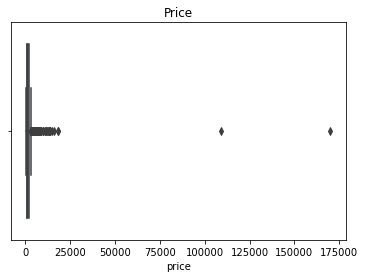

In [12]:
sns.boxplot(x=alquiler.price)
plt.gca().set_title("Price")
plt.show()

Por lo que los eliminamos:

In [13]:
alquiler = alquiler[alquiler.price < 20000]

### Surface


En el caso de la segunda variable, la variable *surface*, vemos que existen algunos valores que también se alejan por la parte superior del conjunto global:

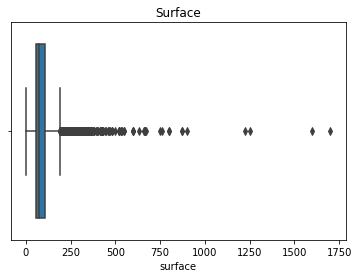

In [14]:
sns.boxplot(x=alquiler.surface)
plt.gca().set_title("Surface")
plt.show()

Pero son valores que entran en los parámetros existentes para ciertas viviendas y es conveniente que el modelo incluya información para ellos.

## Revisión del dominio de algunas columnas
Por último, vamos a ver si existen variables que sólo tengan un valor y las eliminamos ya que no aportan información.

In [15]:
valores_unicos = [v for v in alquiler if len(alquiler[v].unique()) == 1]
alquiler.drop(valores_unicos, axis=1, inplace=True)

# Análisis visual de los datos
## zipCode
Esta variable tiene mucha importancia en la determinación de las características asociadas a un alquiler, y por tanto afecta al precio y a la facilidad para alquilarlo. Por ello vamos a realizar un estudio de la división de los inmueble por código postal.

En primer lugar analizamos el dominio de valores, ya que al ser inmuebles de la ciudad de Madrid, todos los códigos postales deberían empezar por '280*' Cualquier valor que no pertenezca a este código postal lo eliminaremos para no producir resultados inesperados:

In [16]:
zipCode_280 = alquiler.zipCode.str.startswith("280")
alquiler = alquiler[zipCode_280]

Por tener idea de cómo se distribuyen geograficamente los inmuebles vamos a realizar un mapa con la cantidad de inmuebles por código postal

In [17]:
# Cargamos el fichero geojson de la comunidad de madrid y nos quedamos con los códigos postales de madrid ciudad
madrid = gpd.read_file('../data/MADRID.geojson')
madrid = madrid[madrid.COD_POSTAL.str.startswith("280")]

In [18]:
alquiler_zip_count = alquiler.groupby('zipCode').size().to_frame("count")

In [19]:
madrid_map_data = madrid.join(alquiler_zip_count, on="COD_POSTAL")
madrid_map_mercator = madrid_map_data.to_crs(epsg=3857)

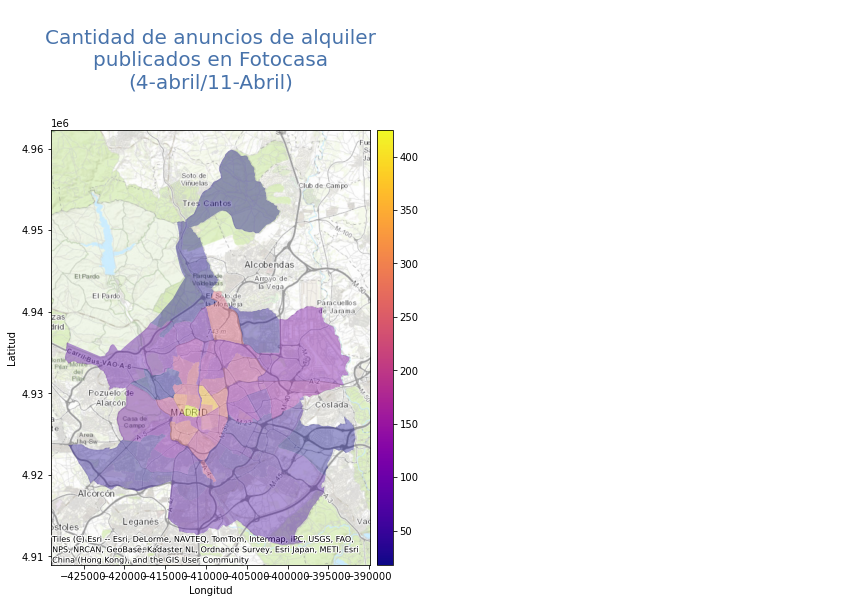

In [20]:
# Control del tamaño de la figura del mapa
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
 
# Control del título y los ejes
title="""
Cantidad de anuncios de alquiler
publicados en Fotocasa
(4-abril/11-Abril)
"""
ax.set_title(title, 
             pad = 20, 
             fontdict={'fontsize':20, 'color': '#4873ab'})
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
 
# Añadir la leyenda separada del mapa

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad="2%", alpha=0.4)
 
# Generar y cargar el mapa
madrid_map_mercator.plot( column="count",
                          alpha=0.4,
                          cmap='plasma', ax=ax,
                          legend=True, cax=cax, 
                          zorder=5)

#ctx.add_basemap(ax, source=ctx.providers.Esri.WorldStreetMap, zoom=12)
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldTopoMap)


Se puede apreciar que en el centro de la ciudad existe más oferta de alquiler que en las zonas periféricas.

## Diagramas de frecuencia

Haremos un primer estudio 

In [21]:
def count_plot(df, col, ax):
    if not ax:
        ax = plt.gca()
    sns.countplot(x=col, data=df, ax=ax)
    ax.set_title(col)
    len_labels = [len(l.get_text()) for l in ax.get_xticklabels()]
    if len(len_labels) > 10:
        ax.set_xticklabels([])
    elif max(len_labels) > 4:
        ax.tick_params(axis="x", rotation=30)
    ax.set_xlabel(None)

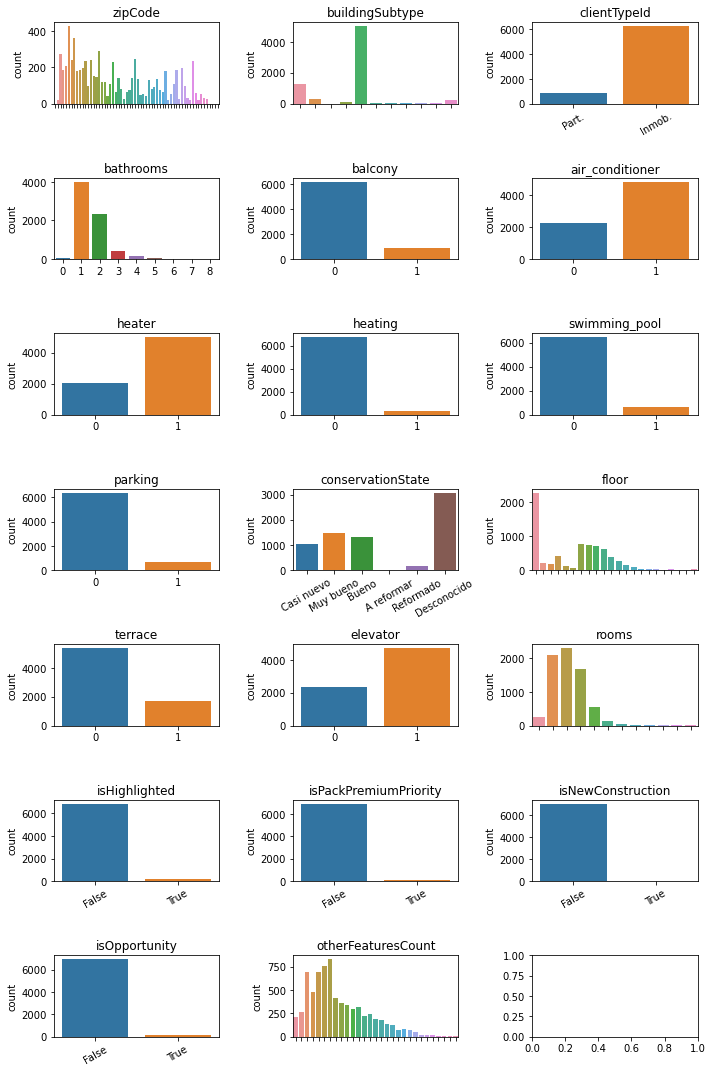

In [22]:
freq_plot = ['zipCode', 'buildingSubtype', 'clientTypeId', 'bathrooms', 'balcony', 'air_conditioner', 'heater',
        'heating', 'swimming_pool', 'parking', 'conservationState', 'floor', 'terrace', 'elevator', 'rooms', 
        'isHighlighted', 'isPackPremiumPriority', 'isNewConstruction', 'isOpportunity', 'otherFeaturesCount']
cols = 3
rows = math.ceil(len(freq_plot) / cols)

fig, axis = plt.subplots(rows, cols, figsize=(10, 15))

axis = axis.flatten()

for i, col in enumerate(freq_plot):
    count_plot(alquiler, col, axis[i])


fig.tight_layout()

Vemos que hay varias variables que contienen valores binarios y que en una gran mayoría de las ocasiones predomina uno de ellos. Podemos ver que de los elementos de la muestra:
* La inmensa mayoría de los anuncios son incluídos por inmobiliarias 95% (clientTypeId)
* En casi ningún caso se utilizan las opciones que promoción de anuncios (isHighslighted, isPackPremiumPriority, isOpportunity)
* La mayoría de los anuncios ofertan pisos de segunda mano
* La característica añadida más común en los anuncios es la presencia de ascensor 72%

## Análisis de correlación entre variables

A continuación vamos a revisar la correlación entre las variables bathrooms, floor, rooms, suface, otherFeaturesCount y price

In [23]:
alqui_plot = alquiler.select_dtypes(exclude=["category","datetime", "object","timedelta","bool"])

In [24]:
sns.set(style="white")

mean = np.zeros(3)
cov = np.random.uniform(.2, .4, (3, 3))
cov += cov.T
cov[np.diag_indices(3)] = 1
data = np.random.multivariate_normal(mean, cov, 100)
df = pd.DataFrame(data, columns=["X", "Y", "Z"])

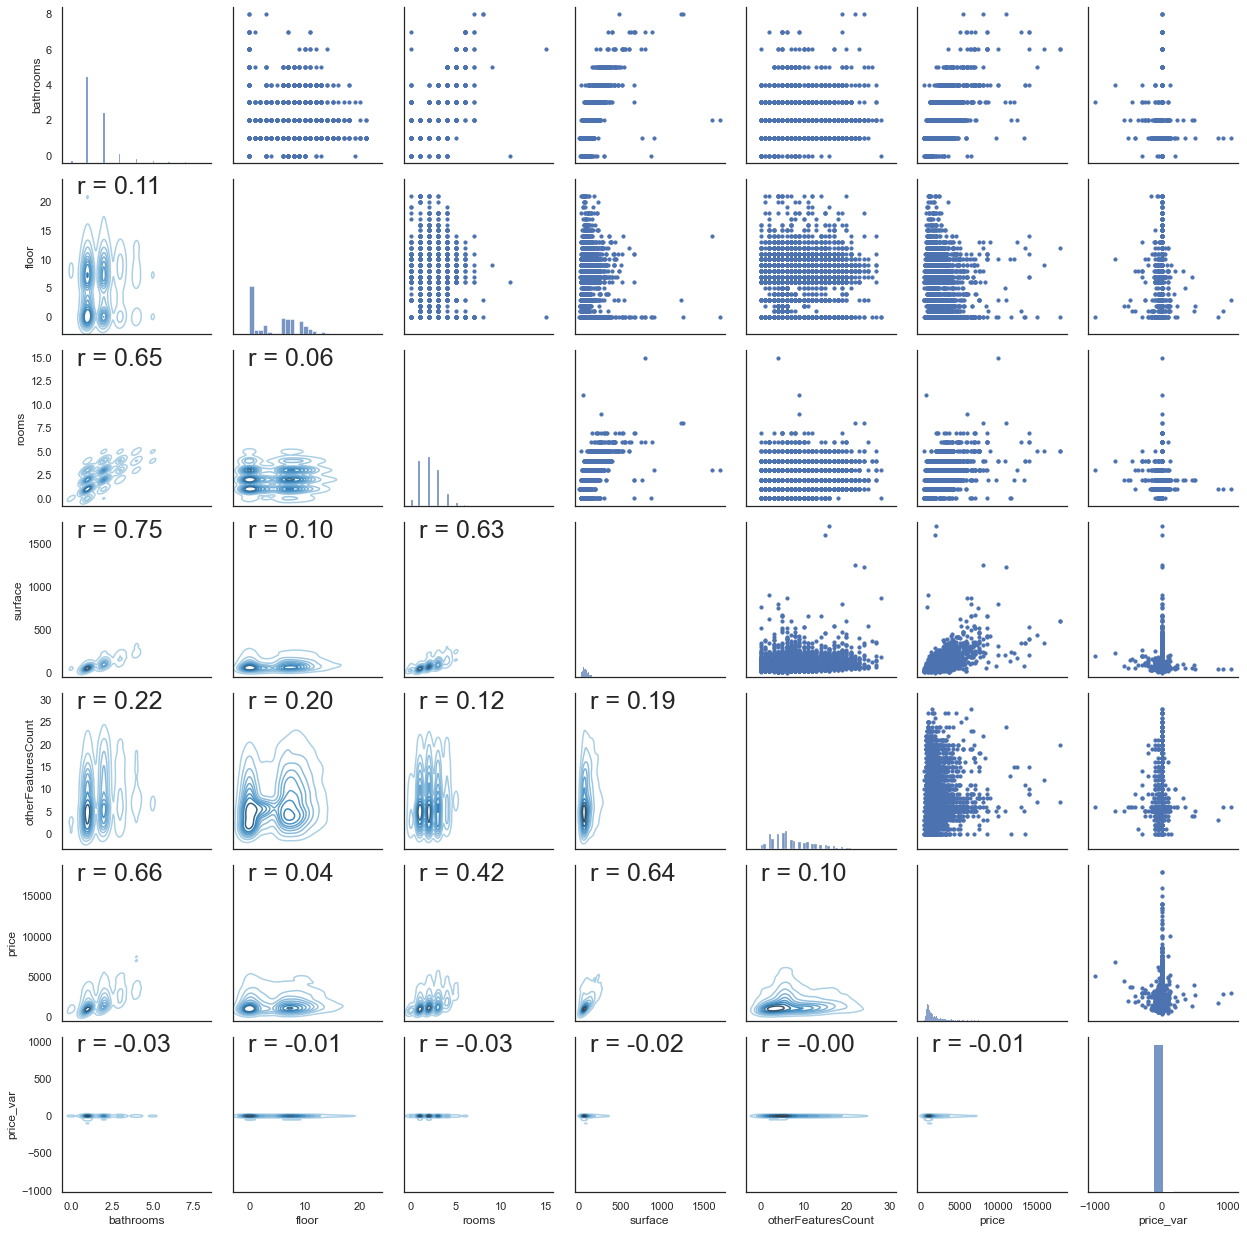

In [25]:
to_pairGrid = alquiler[['bathrooms', 'floor', 'rooms', 
                       'surface', 'otherFeaturesCount', 'price', 'price_var']]

def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes,
                fontsize=25)
    
g = sns.PairGrid(to_pairGrid, palette=["red"])
g.map_upper(plt.scatter, s=10)
g.map_diag(sns.histplot, kde=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_lower(corrfunc)

En este gráfico podemos en la diagonal la representación del histograma de la correspondiente variable, en la zona inferior la función de densidad (con el coeficiente de correlación de Pearson), y en la zona superior el diagrama de dispersión. De esta información podemos concluir que:
* El número de baños tiene una correlación más fuerte con el precio que el número de habitaciones
* También existe una fuerte correlación entre la superficie y el precio
* La planta no determina el precio del alquiler, como tampoco lo hace la cantidad de características adicionales de la vivienda.

## Enriquecimiento de datos

### Latitud y longitud del código postal

Aprovecharemos los datos utilizados para visualizar en el mapa los inmuebles en alquiler por código postal para añadir al dataset las coordenadas geográficas del centro de cada uno de los códigos postales.

Para ello extraeremos del DataFrame `madrid_map_mercator` el `COD_POSTAL` y el centroide de cada polígono (cada código postal), después se añadirán los datos de longitud y latitud del centroide al DataFrame `alquileres`

In [26]:
center_zipCode = madrid_map_mercator['geometry'].centroid
madrid_map_mercator['lon'] = center_zipCode.x
madrid_map_mercator['lat'] = center_zipCode.y

Se han detectado códigos postales 28000 que no existen se transforman a 28001

In [27]:
alquiler.loc[alquiler.zipCode=="28000","zipCode"] = "28001"

Incorporamos en alquiler lat, lon y eliminamos zipCode:

In [28]:
madrid_join = madrid_map_mercator.set_index('COD_POSTAL')

alquiler = alquiler.join(madrid_join[['lon', 'lat']], on="zipCode")
alquiler[:3]

,zipCode,buildingSubtype,clientTypeId,dateOriginal,bathrooms,balcony,air_conditioner,heater,heating,swimming_pool,...,isPackPremiumPriority,isNewConstruction,isOpportunity,otherFeaturesCount,price,periodicityId,lastAccess,price_var,lon,lat
0,28023,GroundFloorWithGarden,Inmob.,2022-02-24,2,0,0,0,0,0,...,True,False,False,15,1325.0,Mensual,2022-04-11 07:48:19.078,0,-421294.598330,4.933792e+06
1,28023,Flat,Inmob.,2022-02-23,2,0,0,0,0,0,...,True,False,False,15,1120.0,Mensual,2022-04-11 07:48:19.139,0,-421294.598330,4.933792e+06
2,28052,GroundFloorWithGarden,Inmob.,2022-03-10,2,0,0,0,0,0,...,True,False,False,18,1095.0,Mensual,2022-04-11 07:49:27.115,0,-395992.473732,4.923984e+06


# Análisis

En ello vamos a estudiar si existe una bajada de precios considerable en los datos obtenidos. Para ello crearemos una nueva columna que tenga el precio inicial del anuncio. Dado que tenemos el precio final (el último publicado) y también la bajada realizada (price_var, negativo bajada, positivo subida) podemos establecer cual era el precio inicial.

Una vez establecido el precio inicial vamos a realizar un contraste de medias entre los precios iniciales y finales de los anuncios que hayan variado de precio para ver si las medias de ambos conjuntos son iguales.

En este caso se da la circunstancia de que los grupos son dependientes, es decir, vamos a estudiar las medias del mismo grupo de individuos antes y después de un evento. Para poder realizar el contraste de hipótesis con el t-test es necesario que ambos grupos sigan una distribución normal.

In [29]:
def visualizeNorm(title_fig, data):
    plt.figure(figsize=(10,4))
    plt.suptitle(title_fig, fontsize=20)

    ax1 = plt.subplot(1,2,1)
    sns.histplot(x=data, kde=True, ax=ax1, line_kws= {'color':'red','linestyle': 'dashed'},)
    ax1.lines[0].set_color('crimson')
    ax1.set_title('Histogram')
    ax1.set_xlabel('Value bin')
    ax1.set_ylabel('Frequency')

    ax2 = plt.subplot(1,2,2)
    qqplot(data, line='s', ax=ax2)
    ax2.set_title('QQ Plot')

    plt.show()

In [30]:
def showShapiroWilkResult(data):
    stat, p_value = shapiro(data)
    print('Statistics=%.3f, p=%.3f' % (stat, p_value))

    alpha = 0.05
    if p_value > alpha:
        print('Gaussian Distributin')
    else:
        print('Non Gaussian Distribution')

    print()

In [31]:
alquiler['price_initial'] = alquiler['price'] - alquiler['price_var']

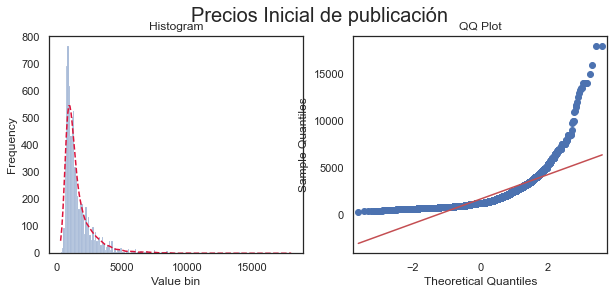

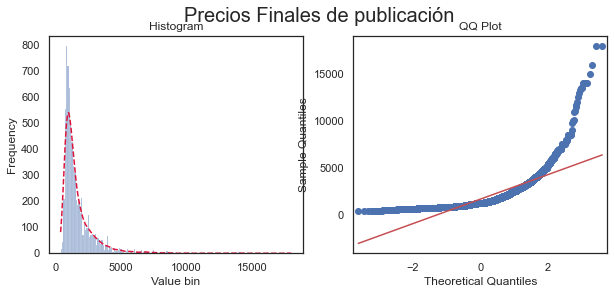

In [32]:
visualizeNorm('Precios Inicial de publicación', alquiler.price_initial)
visualizeNorm('Precios Finales de publicación', alquiler.price)

En los gráficos se aprecia que las variables no siguen una distribución normal, aún así aplicando el test Shapiro-Wilk:

In [33]:
showShapiroWilkResult(alquiler.price_initial)
showShapiroWilkResult(alquiler.price)

Statistics=0.664, p=0.000
Non Gaussian Distribution

Statistics=0.664, p=0.000
Non Gaussian Distribution



/Users/kevin/opt/anaconda3/envs/tdd_pra2/lib/python3.8/site-packages/scipy/stats/_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Verificamos que no se comportan como distribuciones normales.

In [34]:
print(len(alquiler.price_initial))
print(len(alquiler.price))

7054
7054


Si aplicamos el _teorema central del límite_ el conjunto de datos es suficientemente grande (N > 30) para considerar que las medias muestrales siguen una distribución normal.

Para comprobar si existe alguna diferencia entre el antes y el después planteamos el siguiente contraste de hipótesis de dos muestras dependientes sobre la diferencia de medias:


H0 : _μ1_ − _μ2_ = 0

H1 : _μ1_ − _μ2_ <> 0


Donde _μ1_ es la media del precio inicial y μ2 es la media del precio final.

In [35]:
ttest_rel(alquiler.price_initial,  alquiler.price, alternative='two-sided')

Ttest_relResult(statistic=3.99346647507348, pvalue=6.577576304461045e-05)

Debido a que el p-value es menor que el nivel de significancia de 0.05 fijado podemos rechazar la hipótesis nula, por lo que podemos concluir que las bajadas de precios recogidas afectan de forma significativa a la media de los precios.

# Modelo para resolución del problema

Se va a aplicar un modelo supervisado de clasificación. Del conjunto de datos eliminamos determinadas características las cuales pueden ser redundantes para nuestro modelo:

In [36]:
alquiler = alquiler[['buildingSubtype', 'clientTypeId', 'bathrooms', 'balcony', 'air_conditioner', 'heater', 'heating', 
          'swimming_pool', 'parking', 'conservationState', 'floor', 'terrace', 'elevator', 'rooms', 'surface',
          'isHighlighted', 'isPackPremiumPriority', 'isNewConstruction', 'isOpportunity', 'otherFeaturesCount', 
          'lon', 'lat', 'price']]

## Separación en train y test

Antes de realizar la separación entre train y test, se realiza el entrenamiento del transformador de datos para que sepa convertir los valores independientemente de que aparezcan posteriormente en cualquiera de los subconjuntos.

In [37]:
# Es una clase que se puede utilizar dentro de un pipeline para transformar todas las col bool en numéricas.
class BoolToNum (BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y = None):
        _X = X.copy()
        for bcol in _X.select_dtypes("bool").columns.to_list():
            _X[bcol] = _X[bcol].replace({True: 1, False: 0})
        return _X

In [38]:
# Este transformador servirá para adaptar los datos para el entrenamiento y la predicción
def transform_data (X):
    cat_cols = X.select_dtypes(["category", "object"]).columns.to_list()
    num_cols = X.select_dtypes(["number", "bool"]).columns.to_list()
    transformer = make_column_transformer(
        (OneHotEncoder(), cat_cols),
        (StandardScaler(), num_cols),
        remainder='passthrough')


    pipe1 = Pipeline([
        ("boolToNum", BoolToNum()),
        ("transformer", transformer),
    ])

    return pipe1.fit(X)



In [39]:
Xtrain, Xtest, ytrain, ytest = train_test_split(alquiler.loc[:, alquiler.columns!="price"], 
                                                alquiler.price, 
                                                test_size=0.1)

## Construcción del modelo

La función `best_model` nos ayudará a realizar el entrenamiento y validación con diferentes parámetros para el `fine tunning` y pudiendo variar el estimador


In [40]:
def best_model(estimator, params, 
               Xtrain=Xtrain, ytrain=ytrain, 
               scoring="neg_mean_squared_error", return_train_score=True):

    clf = GridSearchCV(estimator=estimator, 
                    param_grid=params, 
                    cv=5,
                    return_train_score=return_train_score,
                    scoring=scoring)

    clf.fit(Xtrain, ytrain)

    print("Best parameters:")
    print(f"Métrica {clf.scoring}: {clf.best_score_:.2f}")
    print(f"Parámetros: {clf.best_params_}")
    return clf

Realizamos una primera prueba con el estimador `RandomForestRegressor()` y variando algunos parámetros como el número de estimadores y la máxima profundidad del árbol. 

In [41]:
params = {
    'bootstrap': [True],
    'max_depth': list(range(9,15)),
    'min_samples_leaf': [5, 6, 7],
    'min_samples_split': [4, 5, 6, 7],
    'n_estimators': list(range(15,25))
}

transform = transform_data(alquiler.loc[:, alquiler.columns != "price"])
clf3 = best_model(RandomForestRegressor(random_state=24), params,
                 Xtrain=transform.transform(Xtrain),
                 ytrain=ytrain)

Best parameters:
Métrica neg_mean_squared_error: -422814.76
Parámetros: {'bootstrap': True, 'max_depth': 14, 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 24}


In [42]:
rmse_rf_train3 = mean_squared_error(ytrain, clf3.predict(transform.transform(Xtrain)))
rmse_rf_test3 = mean_squared_error(ytest, clf3.predict(transform.transform(Xtest)))
r_2_rf_test3 = r2_score(ytest, clf3.predict(transform.transform(Xtest)))
print("RMSE train:", round(rmse_rf_train3,2))
print("RMSE test :", round(rmse_rf_test3,2))
print("R²        :", round(r_2_rf_test3,2))

RMSE train: 250119.74
RMSE test : 203305.8
R²        : 0.84


# Conclusiones

A partir del conjunto de datos podemos observar como se puede obtener determinada información, como por ejemplo, que en la evolución de los precios hay diferencias en intervalos cortos de días, por lo que esperar a que el propietario realice una bajada en el precio podría ser una buena estrategia, ya que estadísticamente se ve que las bajadas afectan a la media de los precios.

Dentro del modelado se ha utilizado RandomForestRegressor mediante las siguientes características obtenidas del procesamiento: buildingSubtype, clientTypeId, bathrooms, balcony, air_conditioner, heater, heating, swimming_pool, parking, conservationState, floor, terrace, elevator, rooms, surface, isHighlighted, isPackPremiumPriority, isNewConstruction, isOpportunity, otherFeaturesCount, lon y lat. Con dicho modelo se ha conseguido obtener un $R^2$ sobre 0.84 con el conjunto de test.

# Contribuciones

Contribuciones realizadas por cada uno de los autores en las
diversas tareas realizadas. Las iniciales en la sección de firma representan la confirmación por
parte del autor de su participación en el apartado correspondiente.

| Contribución  | Firma   |
|---------------|---------|
| Planteamiento del problema | KM - JV  |
| Limpieza del dataset       | KM - JV  |
| Análisis estadístico       | KM - JV  |
| Modelo del problema        | KM - JV  |